In [ ]:
# This code has been modified from the original.

# Modifications (September 2, 2025):
# - Implemented a kidney stone detection pipeline using a Quantum Convolutional Neural Network (QCNN) on a custom medical image dataset.
# - Integrated Google Drive for easy access and added dataset I/O helper functions: load_images_from_folder() and count_imgs().
# - Preprocessing steps include converting images to grayscale, resizing them to 16×16 pixels, flattening to a 256-dimensional array, and normalizing pixel values to the range [0, 1].
# - Applied dimensionality reduction using PCA (n_components=8) to facilitate 8-qubit encoding; scaled features to the range [0, π] for epsilon-safety.
# - Data splitting was performed using a stratified train/test split, preserving the original indices for later visualization.
# - Mapped class labels to {-1: "No Stone", +1: "Stone"} for binary classification.
# - Ensured compatibility with Qiskit by pinning specific package versions (qiskit==1.4.2, qiskit-machine_learning==0.8.2, etc.).
# - Imported Robust Estimator across backends (StatevectorEstimator → Estimator → Aer Estimator fallback).
# - Changed the optimizer import to qiskit_algorithms.optimizers.COBYLA and set maxiter to 200.
# - Integrated and reused QCNN building blocks (conv_circuit, conv_layer, pool_circuit, pool_layer) with ZFeatureMap(8).
# - Constructed the EstimatorQNN with observable Z ⊗ I^7; utilized the decompose() method to avoid unnecessary data copying.
# - Added a training callback function, callback_graph(), to live-plot the objective value during each iteration.
# - Included an optional warm-start feature to load the initial point from Drive, including a length check and safe fallback.
# - Enhanced evaluation metrics to include precision, recall, F1 score, ROC-AUC, classification report, confusion matrix, and ROC curve.
# - Added robust handling for probability outputs, inferring the positive-class column while guarding against single-class test sets.
# - Included visualization tools to preview a preprocessed 16×16 image and display a gallery of test images with predicted and true labels.
# - Ensured safety and reproducibility with fast-fail mechanisms for missing or empty folders, fixed seeds (for NumPy and algorithm_globals), and suppressed warnings.

# Modified by: Md. Shakhawat Hossain
# Department of Electrical and Computer Engineering
# North South University
# Plot # 15, Block # B, Bashundhara
# Dhaka – 1229, Bangladesh

# (C) Copyright IBM 2017, 2025.
# SPDX-License-Identifier: Apache-2.0
# Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q qiskit==1.4.2 qiskit-machine_learning==0.8.2 qiskit-algorithms qiskit-aer pylatexenc

# 1. Imports

import os, json, warnings
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import clear_output

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

# Robust Estimator import across common Qiskit 1.x setups

try:
    from qiskit.primitives import StatevectorEstimator as Estimator  # may exist in some 1.x combos
except Exception:
    try:
        from qiskit.primitives import Estimator  # Terra Estimator
    except Exception:
        from qiskit_aer.primitives import Estimator  # Aer fallback

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# 2. Reproducibility

warnings.filterwarnings("ignore")
np.random.seed(12345)
algorithm_globals.random_seed = 12345
estimator = Estimator()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.3 MB/s eta 0:00:00


In [ ]:
# 3. Data loading
#    Loads images from a folder, converts to grayscale,
#    resizes to 16x16, flattens to 256, and normalizes to [0,1].
#    Returns (images, labels) as lists.

def load_images_from_folder(folder_path, label):

    images, labels = [], []
    for fn in os.listdir(folder_path):
        if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(folder_path, fn)).convert('L')
            img = img.resize((16, 16), Image.BILINEAR)
            arr = np.array(img).flatten().astype(np.float32) / 255.0
            images.append(arr)
            labels.append(label)
    return images, labels

def count_imgs(p):
    return sum(fn.lower().endswith(('.png', '.jpg', '.jpeg')) for fn in os.listdir(p))

# 4. Drive folders

folder_stone  = "/content/drive/MyDrive/Kidney Stone Ultrasound Images/stone"
folder_normal = "/content/drive/MyDrive/Kidney Stone Ultrasound Images/Normal"

# 5. Fast-fail guards

for p in [folder_stone, folder_normal]:
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Folder not found: {p}\n"
                                "Check that Drive is mounted and paths are correct.")
if count_imgs(folder_stone) == 0 or count_imgs(folder_normal) == 0:
    raise RuntimeError("One of the folders has no images. Add images to both 'Stone' and 'Normal'.")

# 6. Load data

stone_imgs, stone_lbls   = load_images_from_folder(folder_stone,  1)
normal_imgs, normal_lbls = load_images_from_folder(folder_normal, -1)

# 7. Stack into arrays

X = np.vstack([stone_imgs, normal_imgs])   # shape: (n_samples, 256)
y = np.hstack([stone_lbls, normal_lbls])   # shape: (n_samples,)

print(f"Loaded dataset: {X.shape[0]} samples | features: {X.shape[1]}")
print(f"Class counts: Stone={np.sum(y==1)}, No Stone={np.sum(y==-1)}")

Loaded dataset: 9419 samples | features: 256
Class counts: Stone=5005, No Stone=4414


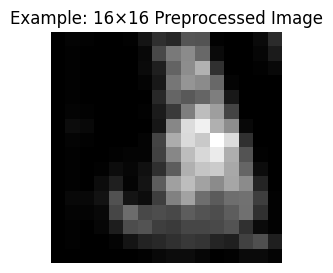

In [ ]:
# 8. PCA to 8 features

pca = PCA(n_components=8, random_state=12345)
X_reduced = pca.fit_transform(X)  # shape: (n_samples, 8)

# 9. Scale PCA features to [0, π] for angle encoding (epsilon-safe)

_min, _max = X_reduced.min(), X_reduced.max()
rng = _max - _min
if rng < 1e-12:
    X_angles = np.zeros_like(X_reduced)
else:
    X_angles = (X_reduced - _min) / rng * np.pi

# 10. Train/test split (stratified) and keep indices to original images

idx_all = np.arange(len(y))
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_angles, y, idx_all,
    test_size=0.3, random_state=42, stratify=y
)

# 11. Preview one original preprocessed image

plt.figure(figsize=(3,3))
plt.imshow(X[0].reshape(16,16), cmap='gray')
plt.title("Example: 16×16 Preprocessed Image")
plt.axis('off')
plt.show()

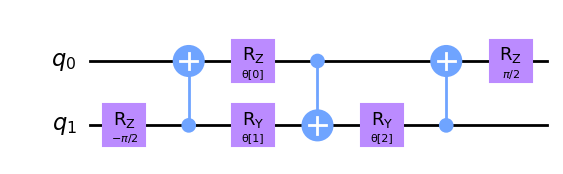

In [ ]:
# 12. QCNN Building Blocks
def conv_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi/2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    qc.cx(1, 0)
    qc.rz(np.pi/2, 0)
    return qc

params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

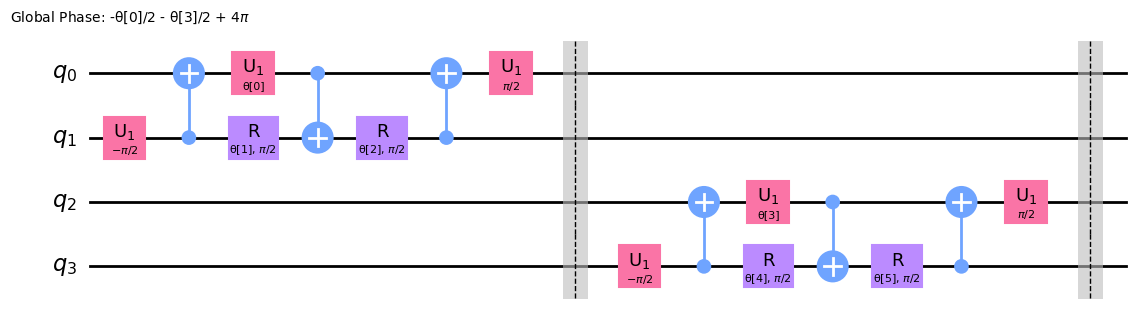

In [ ]:
def conv_layer(num_qubits, prefix):
    """Tiles conv_circuit across adjacent qubit pairs."""
    qc = QuantumCircuit(num_qubits, name=f"Conv_{prefix}")
    params = ParameterVector(prefix, length=(num_qubits//2)*3)
    idx = 0
    for i in range(0, num_qubits, 2):
        qc.compose(conv_circuit(params[idx:idx+3]), [i, i+1], inplace=True)
        qc.barrier()
        idx += 3
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

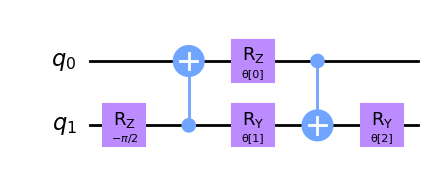

In [ ]:
def pool_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi/2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    return qc

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

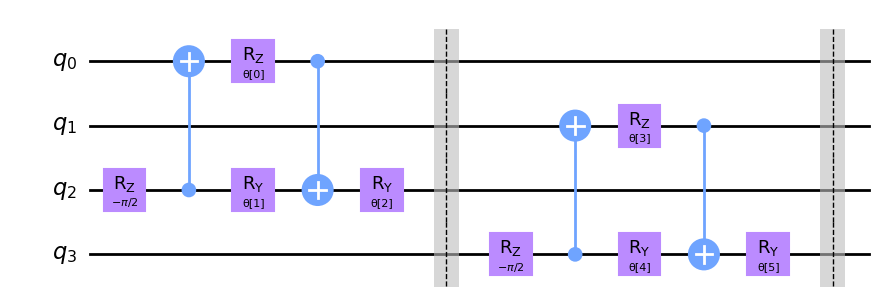

In [ ]:
#    Builds a pooling layer that acts on len(sources)+len(sinks) local wires.
#    When composing into the full ansatz, pass an index map to place it on target qubits.

def pool_layer(sources, sinks, prefix):

    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name=f"Pool_{prefix}")
    params = ParameterVector(prefix, length=(num_qubits//2)*3)
    idx = 0
    for s, t in zip(sources, sinks):
        qc.compose(pool_circuit(params[idx:idx+3]), [s, t], inplace=True)
        qc.barrier()
        idx += 3
    inst = qc.to_instruction()
    full = QuantumCircuit(num_qubits)
    full.append(inst, range(num_qubits))
    return full

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

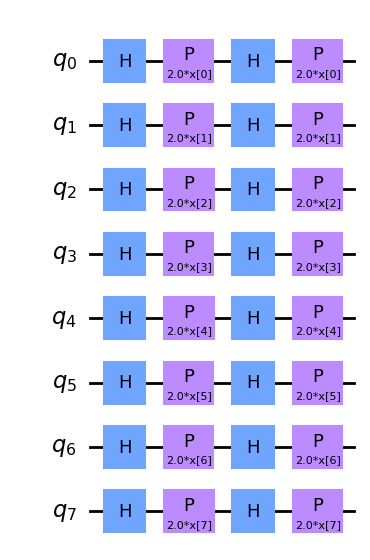

In [ ]:
# 14. Feature map
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [ ]:
# 13. Build QCNN Ansatz (8 qubits)

ansatz = QuantumCircuit(8, name="Ansatz")
ansatz.compose(conv_layer(8, "c1"),  list(range(8)), inplace=True)
ansatz.compose(pool_layer([0,1,2,3], [4,5,6,7], "p1"), list(range(8)), inplace=True)
ansatz.compose(conv_layer(4, "c2"),  list(range(4,8)), inplace=True)
ansatz.compose(pool_layer([0,1],     [2,3],     "p2"), list(range(4,8)), inplace=True)
ansatz.compose(conv_layer(2, "c3"),  list(range(6,8)), inplace=True)
ansatz.compose(pool_layer([0],       [1],       "p3"), list(range(6,8)), inplace=True)

# 14. Feature map and full circuit

feature_map = ZFeatureMap(8)
qc = QuantumCircuit(8)
qc.compose(feature_map, list(range(8)), inplace=True)
qc.compose(ansatz,      list(range(8)), inplace=True)

# 15. Observable for binary classification

observable = SparsePauliOp.from_list([("Z" + "I"*7, 1.0)])

# 16. Build EstimatorQNN

qnn = EstimatorQNN(
    circuit=qc.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

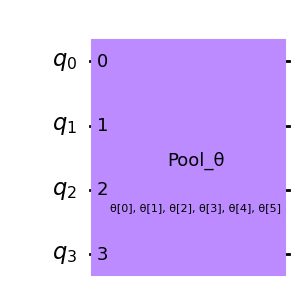

In [ ]:
circuit.draw("mpl", style="clifford")

In [ ]:
# 18) load initial point

init_pt = None
init_path = "/content/drive/MyDrive/11_qcnn_initial_point.json"
try:
    with open(init_path, "r") as f:
        init_pt = json.load(f)
    if init_pt is not None and len(init_pt) != qnn.num_weights:
        print(f"[WARN] Initial point length {len(init_pt)} != qnn.num_weights {qnn.num_weights}. Ignoring.")
        init_pt = None
except FileNotFoundError:
    pass

# 19. Build classifier

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=init_pt
)

# 20. Train

x_train_arr = np.asarray(x_train)
y_train_arr = np.asarray(y_train)
classifier.fit(x_train_arr, y_train_arr)

# 17. Training callback (plots objective)
objective_vals = []
def callback_graph(weights, value):
    clear_output(wait=True)
    objective_vals.append(float(value))
    plt.plot(objective_vals, '-o')
    plt.title("Objective value vs. iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective value")
    plt.show()


[WARN] Initial point length 63 != qnn.num_weights 42. Ignoring.


In [ ]:
# 21. Performance metrics

train_acc = 100 * classifier.score(x_train_arr, y_train_arr)
test_acc  = 100 * classifier.score(np.asarray(x_test), np.asarray(y_test))
print(f"\nTrain Accuracy: {train_acc:.2f}%")
print(f"Test  Accuracy: {test_acc:.2f}%\n")

# 22. Predictions & probabilities (robust to lack of `classes_`)

y_pred = classifier.predict(x_test)
probs  = classifier.predict_proba(x_test)

# Determine positive-class (+1) column robustly (no reliance on `classes_`)

classes = np.unique(y_train_arr)            # e.g., array([-1,  1])

if probs.ndim == 1:
    y_prob_pos = probs.ravel()
elif probs.shape[1] == 1: # Handle case where probs is 2D but only has one column
    # Check if the positive class (1) is present in the test set
    if 1 in np.unique(y_test):
        y_prob_pos = probs.ravel() # Only positive class in test set
    else:
        y_prob_pos = np.zeros_like(probs.ravel()) # Only negative class in test set
else:
    pos_index = int(np.where(classes == 1)[0][0])
    y_prob_pos = probs[:, pos_index]


# Precision, Recall, F1, AUC-ROC

prec = precision_score(y_test, y_pred, pos_label=1)
rec  = recall_score(y_test, y_pred, pos_label=1)
f1   = f1_score(y_test, y_pred, pos_label=1)
try:
    auc  = roc_auc_score(y_test, y_prob_pos)
except ValueError:
    auc = float("nan")  # happens if y_test has a single class

print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"AUC-ROC   : {auc:.4f}\n")


Train Accuracy: 73.23%
Test  Accuracy: 74.13%

Precision : 0.7660
Recall    : 0.7430
F1-score  : 0.7543
AUC-ROC   : 0.8215



In [ ]:
# Detailed classification report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Stone","Stone"]))

Classification Report:
              precision    recall  f1-score   support

    No Stone       0.72      0.74      0.73      1324
       Stone       0.77      0.74      0.75      1502

    accuracy                           0.74      2826
   macro avg       0.74      0.74      0.74      2826
weighted avg       0.74      0.74      0.74      2826



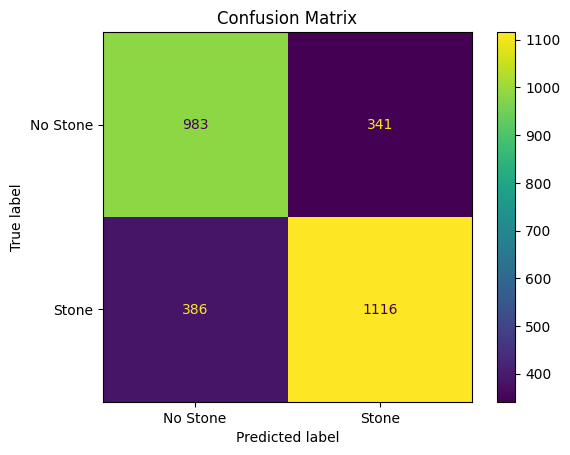

In [ ]:
# 23. Confusion Matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stone", "Stone"])
disp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

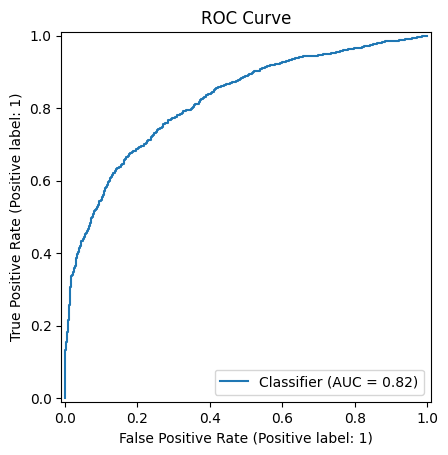

In [ ]:
# 24. ROC Curve (only if both classes present)

if len(np.unique(y_test)) == 2:
    RocCurveDisplay.from_predictions(y_test, y_prob_pos)
    plt.title("ROC Curve")
    plt.show()
else:
    print("ROC curve skipped (y_test contains a single class).")



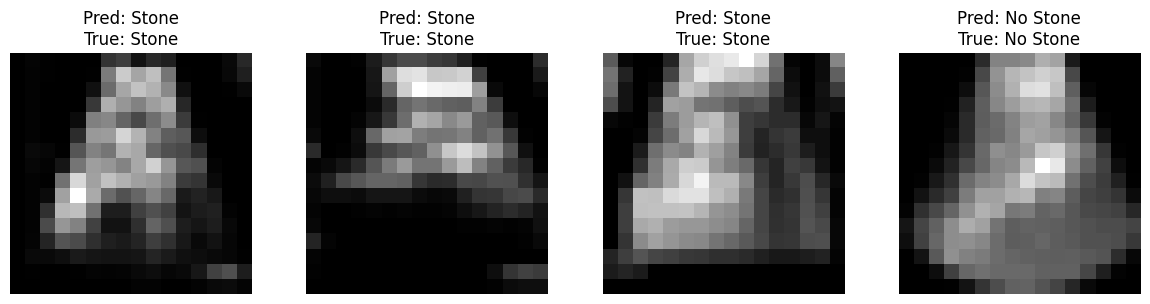

In [ ]:
# 25. Visualize original 16×16 test images with predicted vs true labels

n_show = min(4, len(idx_test))
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
if n_show == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    j = idx_test[i]  # original index
    ax.imshow(X[j].reshape(16,16), cmap='gray')
    pred = "Stone" if y_pred[i] == 1 else "No Stone"
    true = "Stone" if y_test[i] == 1 else "No Stone"
    ax.set_title(f"Pred: {pred}\nTrue: {true}")
    ax.axis('off')
plt.tight_layout()
plt.show()